[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/joshmaglione/CS102-Jupyter/main?labpath=.%2FWeek07.ipynb) 

<a href="https://colab.research.google.com/github/joshmaglione/CS102-Jupyter/blob/main/Week07.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

[View on GitHub](https://github.com/joshmaglione/CS102-Jupyter/blob/main/Week07.ipynb)

# Week 7: Working with DataFrames

Last time we discussed the three main data structures `pandas` brings.

Now we will discuss how to manipulate the primary object: DataFrames.

Let's load in UN data about Ireland from two files sources: 
- `data/01_below_poverty.csv`
- `data/07_renewable_energy.csv`

(This was obtained from the [United Nations' SDG Country Profile Page](https://unstats.un.org/sdgs/dataportal/countryprofiles/IRL))

This data has lots of information that we don't need, so our goal is to produce one DataFrame with the information we want. 

In [17]:
import pyarrow as pa        # To shut the pandas warning up.
import pandas as pd
pd.__version__

'2.2.0'

## Below Poverty Data Set

We'll work through some of the basics with the below poverty data set.

In [2]:
df1 = pd.read_csv("data/01_below_poverty.csv")
df1.head()

,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,...,BasePeriod,Source,GeoInfoUrl,FootNote,[Age],[Location],[Nature],[Reporting Type],[Sex],[Units]
0,1.0,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,372.0,Ireland,1987.0,0.7,1987.0,...,2017.0,"Poverty and Inequality Portal, World Bank",NaN,"Accessed March 21, 2023. Based on data from SI...",ALLAGE,ALLAREA,G,G,BOTHSEX,PERCENT
1,1.0,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,372.0,Ireland,1994.0,0.2,1994.0,...,2017.0,"Poverty and Inequality Portal, World Bank",NaN,"Accessed March 21, 2023. Based on data from LI...",ALLAGE,ALLAREA,G,G,BOTHSEX,PERCENT
2,1.0,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,372.0,Ireland,1995.0,0.2,1995.0,...,2017.0,"Poverty and Inequality Portal, World Bank",NaN,"Accessed March 21, 2023. Based on data from LI...",ALLAGE,ALLAREA,G,G,BOTHSEX,PERCENT
3,1.0,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,372.0,Ireland,1996.0,0.2,1996.0,...,2017.0,"Poverty and Inequality Portal, World Bank",NaN,"Accessed March 21, 2023. Based on data from LI...",ALLAGE,ALLAREA,G,G,BOTHSEX,PERCENT
4,1.0,1.1,1.1.1,SI_POV_DAY1,Proportion of population below international p...,372.0,Ireland,2000.0,0.2,2000.0,...,2017.0,"Poverty and Inequality Portal, World Bank",NaN,"Accessed March 21, 2023. Based on data from LI...",ALLAGE,ALLAREA,G,G,BOTHSEX,PERCENT


Most of the columns look irrelevant. Let's look to keep the columns
- "TimePeriod"
- "Value"
- "Time_Detail"
- "[Age]"
- "[Location]"
- "[Sex]"

In [3]:
df1 = df1[[
	"TimePeriod",
	"Value",
	"Time_Detail",
	"[Age]",
	"[Location]",
	"[Sex]"
]]
df1.head()

,TimePeriod,Value,Time_Detail,[Age],[Location],[Sex]
0,1987.0,0.7,1987.0,ALLAGE,ALLAREA,BOTHSEX
1,1994.0,0.2,1994.0,ALLAGE,ALLAREA,BOTHSEX
2,1995.0,0.2,1995.0,ALLAGE,ALLAREA,BOTHSEX
3,1996.0,0.2,1996.0,ALLAGE,ALLAREA,BOTHSEX
4,2000.0,0.2,2000.0,ALLAGE,ALLAREA,BOTHSEX


It's weird that `"TimePeriod"` is a float. Let's change this to an int.

In [4]:
# df1.astype({"TimePeriod" : "i"})

We need to clean our data before we can manipulate it. Let's remove the rows where `"TimePeriod"` is empty.

In [5]:
df1.dropna(subset="TimePeriod", inplace=True)
df1 = df1.astype({"TimePeriod" : "i"})
df1

,TimePeriod,Value,Time_Detail,[Age],[Location],[Sex]
0,1987,0.70000,1987.0,ALLAGE,ALLAREA,BOTHSEX
1,1994,0.20000,1994.0,ALLAGE,ALLAREA,BOTHSEX
2,1995,0.20000,1995.0,ALLAGE,ALLAREA,BOTHSEX
3,1996,0.20000,1996.0,ALLAGE,ALLAREA,BOTHSEX
4,2000,0.20000,2000.0,ALLAGE,ALLAREA,BOTHSEX
...,...,...,...,...,...,...
145,2020,0.15064,2020.0,15-64,ALLAREA,BOTHSEX
146,2020,0.08503,2020.0,<15Y,ALLAREA,BOTHSEX
147,2020,0.10854,2020.0,ALLAGE,URBAN,BOTHSEX
148,2020,0.19978,2020.0,ALLAGE,RURAL,BOTHSEX


We are not going to span the entirity of this data set. Let's just take the years 2005 to 2020.

In [6]:
df1.query("2005 <= TimePeriod <= 2020", inplace=True)
df1

,TimePeriod,Value,Time_Detail,[Age],[Location],[Sex]
22,2005,0.00000,2005.0,ALLAGE,ALLAREA,BOTHSEX
23,2005,0.03139,2005.0,15-64,ALLAREA,BOTHSEX
24,2005,0.03699,2005.0,65+,ALLAREA,BOTHSEX
25,2005,0.02371,2005.0,ALLAGE,ALLAREA,FEMALE
26,2005,0.03108,2005.0,ALLAGE,ALLAREA,MALE
...,...,...,...,...,...,...
145,2020,0.15064,2020.0,15-64,ALLAREA,BOTHSEX
146,2020,0.08503,2020.0,<15Y,ALLAREA,BOTHSEX
147,2020,0.10854,2020.0,ALLAGE,URBAN,BOTHSEX
148,2020,0.19978,2020.0,ALLAGE,RURAL,BOTHSEX


The `"Time_Detail"` column looks irrelevant. Let's look at all the values.

In [7]:
df1["Time_Detail"].value_counts()

Time_Detail
2005.0    8
2006.0    8
2007.0    8
2008.0    8
2009.0    8
2010.0    8
2011.0    8
2012.0    8
2013.0    8
2014.0    8
2015.0    8
2016.0    8
2017.0    8
2018.0    8
2019.0    8
2020.0    8
Name: count, dtype: int64

In [8]:
df1.drop(["Time_Detail"], axis=1, inplace=True)
df1

,TimePeriod,Value,[Age],[Location],[Sex]
22,2005,0.00000,ALLAGE,ALLAREA,BOTHSEX
23,2005,0.03139,15-64,ALLAREA,BOTHSEX
24,2005,0.03699,65+,ALLAREA,BOTHSEX
25,2005,0.02371,ALLAGE,ALLAREA,FEMALE
26,2005,0.03108,ALLAGE,ALLAREA,MALE
...,...,...,...,...,...
145,2020,0.15064,15-64,ALLAREA,BOTHSEX
146,2020,0.08503,<15Y,ALLAREA,BOTHSEX
147,2020,0.10854,ALLAGE,URBAN,BOTHSEX
148,2020,0.19978,ALLAGE,RURAL,BOTHSEX


The last four columns are potentially irrelevant. Let's see what the possibilities are for 
- "[Age]"
- "[Location]"
- "[Sex]"

We want the most inclusive options.

Let's look at the rows for one particular year. 

In [9]:
df1.query("2011 == TimePeriod")

,TimePeriod,Value,[Age],[Location],[Sex]
70,2011,0.50000,ALLAGE,ALLAREA,BOTHSEX
71,2011,0.08366,<15Y,ALLAREA,BOTHSEX
72,2011,0.67060,15-64,ALLAREA,BOTHSEX
73,2011,0.65755,65+,ALLAREA,BOTHSEX
74,2011,0.40174,ALLAGE,ALLAREA,FEMALE
75,2011,0.69121,ALLAGE,ALLAREA,MALE
76,2011,0.59732,ALLAGE,RURAL,BOTHSEX
77,2011,0.51095,ALLAGE,URBAN,BOTHSEX


The data set has lots of granularity. Let's just take the coarse, general information.

In [10]:
df1 = df1[
	(df1["[Age]"] == "ALLAGE") & 
	(df1["[Location]"] == "ALLAREA") &
	(df1["[Sex]"] == "BOTHSEX")
]
df1

,TimePeriod,Value,[Age],[Location],[Sex]
22,2005,0.0,ALLAGE,ALLAREA,BOTHSEX
37,2006,0.4,ALLAGE,ALLAREA,BOTHSEX
38,2007,0.1,ALLAGE,ALLAREA,BOTHSEX
53,2008,0.2,ALLAGE,ALLAREA,BOTHSEX
54,2009,0.5,ALLAGE,ALLAREA,BOTHSEX
69,2010,0.5,ALLAGE,ALLAREA,BOTHSEX
70,2011,0.5,ALLAGE,ALLAREA,BOTHSEX
79,2012,0.3,ALLAGE,ALLAREA,BOTHSEX
93,2013,0.7,ALLAGE,ALLAREA,BOTHSEX
94,2014,0.4,ALLAGE,ALLAREA,BOTHSEX


Now that the last three columns are constant, we will drop them.

In [11]:
df1.drop(["[Age]", "[Location]", "[Sex]"], axis=1, inplace=True)
df1

/var/folders/yx/6xxgqk752rx1t36vzf7hncrm0000gn/T/ipykernel_4069/1278849235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(["[Age]", "[Location]", "[Sex]"], axis=1, inplace=True)


,TimePeriod,Value
22,2005,0.0
37,2006,0.4
38,2007,0.1
53,2008,0.2
54,2009,0.5
69,2010,0.5
70,2011,0.5
79,2012,0.3
93,2013,0.7
94,2014,0.4


The current index is also irrelevant. Let's convert `"TimePeriod"` to our index. 

In [12]:
df1.set_index("TimePeriod", inplace=True)
df1

,Value
TimePeriod,
2005,0.0
2006,0.4
2007,0.1
2008,0.2
2009,0.5
2010,0.5
2011,0.5
2012,0.3
2013,0.7


Lastly, let's change `"Value"` to `"Below Poverty (%)"`.

In [13]:
df1.rename(columns={"Value" : "Below Poverty (%)"}, inplace=True)
df1

/var/folders/yx/6xxgqk752rx1t36vzf7hncrm0000gn/T/ipykernel_4069/1387673251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={"Value" : "Below Poverty (%)"}, inplace=True)


,Below Poverty (%)
TimePeriod,
2005,0.0
2006,0.4
2007,0.1
2008,0.2
2009,0.5
2010,0.5
2011,0.5
2012,0.3
2013,0.7


## Speedrun: Renewable Energy Data Set

We will basically do the same steps as above, but all at once. See if you can follow along line by line.

In [14]:
df2 = pd.read_csv("data/07_renewable_energy.csv")
df2 = df2[["TimePeriod", "Value"]]
df2.dropna(inplace=True)
df2 = df2.astype({"TimePeriod" : "i"})
df2.set_index("TimePeriod", inplace=True)
df2 = df2.loc["2005":"2020"]
df2.rename(columns={"Value" : "Renewable Energy Share (%)"}, inplace=True)
df2

,Renewable Energy Share (%)
TimePeriod,
2005,2.89
2006,3.23
2007,3.55
2008,4.19
2009,5.30
2010,5.29
2011,6.96
2012,6.90
2013,7.71


## From two to one

Because our two DataFrames have the same index, we can concatenate them in `pandas`.

In [15]:
df = pd.concat([df1, df2], axis=1)		# Merging our two DataFrames
df.index.names = ["Year"]				# Renaming the index
df

,Below Poverty (%),Renewable Energy Share (%)
Year,,
2005,0.0,2.89
2006,0.4,3.23
2007,0.1,3.55
2008,0.2,4.19
2009,0.5,5.30
2010,0.5,5.29
2011,0.5,6.96
2012,0.3,6.90
2013,0.7,7.71


#### Detour: visualization

We'll discuss this more later, but we can now plot the DataFrame on a set of axes with `Matplotlib`.

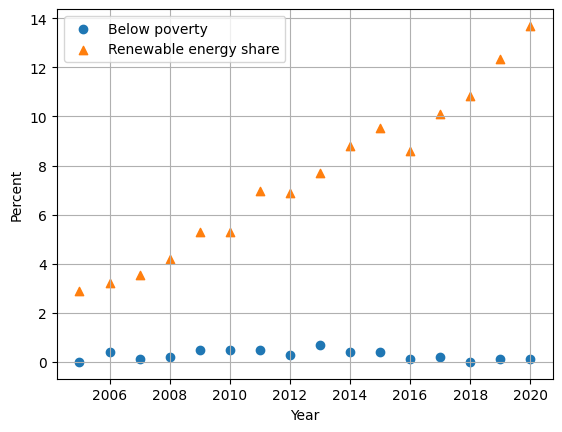

In [16]:
import matplotlib.pyplot as plt 
plt.grid()
plt.scatter(
	df.index, 
	df["Below Poverty (%)"], 
	marker='o', 
	label="Below poverty"
)
plt.scatter(
	df.index, 
	df["Renewable Energy Share (%)"], 
	marker="^", 
	label="Renewable energy share"
)
plt.xlabel("Year")
plt.ylabel("Percent")
plt.legend()
plt.show()

## Ufuncs

All the `NumPy` UFuncs can be applied to DataFrames, provided they are applied to appropriate numerical data. 